![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desasrrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/t/4bd64c1deb3c4ffb8ca7ff93c1f1497d).

## Datos para la predicción de precios de vehículos usados

En este proyecto se usará el conjunto de datos de Car Listings de Kaggle, donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como: año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

## Informe

### Bloque de Importacion de Librerias Utilizadas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Preprocesamiento de los Datos

A continuación iniciamos con la carga de los datos crudos entregados por la competencia de Kaggle y se transforman en dataframes de pandas para poder operar sobre ellos:

In [3]:
# Carga de datos crudos de archivo .csv
raw_dataTraining = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
raw_dataTesting = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTest_carListings.zip', index_col=0)

In [4]:
# Visualización datos de entrenamiento
print(raw_dataTraining.info())
raw_dataTraining.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB
None


,Price,Year,Mileage,State,Make,Model
0,34995,2017,9913,FL,Jeep,Wrangler
1,37895,2015,20578,OH,Chevrolet,Tahoe4WD
2,18430,2012,83716,TX,BMW,X5AWD
3,24681,2014,28729,OH,Cadillac,SRXLuxury
4,26998,2013,64032,CO,Jeep,Wrangler


Podemos observar que los datos de entrenamiento estan compuestos:

- 400.000 registros.
- 3 variables de tipo 'Integer'.
- 3 variables de tipo 'object' es decir, son variables que principalmente estan compuestas por 'Strings'.
- No existen valores o registros de tipo null o NaN.

Sin embargo, debemos resaltar que al buscar un modelo de regresión para la variable 'Price' las variables que son de tipo 'object' deben ser transformadas en numeros que serán interpretados por el modelo. Así que iniciamos un analisis sobre las variables de tipo 'object':

In [5]:
# Validemos cuantas y cuales son las caracteristicas unicas de cada variable categorica:
for c in range(0, len(raw_dataTraining.columns)):
    if (raw_dataTraining[raw_dataTraining.columns[c]].dtype == 'object'):
        print(f"\nValores unicos de la variable categorica: {raw_dataTraining.columns[c]}\n")
        print(f"Cantidad: {len(raw_dataTraining[raw_dataTraining.columns[c]].unique())}\n")
        print(raw_dataTraining[raw_dataTraining.columns[c]].unique())
        print("-"*100)
        


Valores unicos de la variable categorica: State

Cantidad: 51

[' FL' ' OH' ' TX' ' CO' ' ME' ' WA' ' CT' ' CA' ' LA' ' NY' ' PA' ' SC'
 ' ND' ' NC' ' GA' ' AZ' ' TN' ' KY' ' NJ' ' UT' ' IA' ' AL' ' NE' ' IL'
 ' OK' ' MD' ' NV' ' WV' ' MI' ' VA' ' WI' ' MA' ' OR' ' IN' ' NM' ' MO'
 ' HI' ' KS' ' AR' ' MN' ' MS' ' MT' ' AK' ' VT' ' SD' ' NH' ' DE' ' ID'
 ' RI' ' WY' ' DC']
----------------------------------------------------------------------------------------------------

Valores unicos de la variable categorica: Make

Cantidad: 38

['Jeep' 'Chevrolet' 'BMW' 'Cadillac' 'Mercedes-Benz' 'Toyota' 'Buick'
 'Dodge' 'Volkswagen' 'GMC' 'Ford' 'Hyundai' 'Mitsubishi' 'Honda' 'Nissan'
 'Mazda' 'Volvo' 'Kia' 'Subaru' 'Chrysler' 'INFINITI' 'Land' 'Porsche'
 'Lexus' 'MINI' 'Lincoln' 'Audi' 'Ram' 'Mercury' 'Tesla' 'FIAT' 'Acura'
 'Scion' 'Pontiac' 'Jaguar' 'Bentley' 'Suzuki' 'Freightliner']
----------------------------------------------------------------------------------------------------

Valores

Encontramos entonces que las variables _**'state', 'make' y 'model'**_ tienen 51, 38 y 525 categorias unicas en nuestros datos y sobre las cuales debemos realizar operaciones de codificación o transformación para poder se ingresadas en nuestro modelo regresor.

Para esto contemplamos varias estrategias:

1. Codificación de Frecuencias.
2. Codificación One Hot.
3. Eliminación de Variables Categoricas.

La codificación por frecuencias podría añadir ruido al modelo ya que le da un peso o valor de acuerdo la cantidad de veces que se repite un tipo de vehiculo y relacionar la _"popularidad"_ con el precio podría no ser tan acertado en este ejercicio. 

La estrategia de eliminar las variables categoricas, teniendo en cuenta que estas representan por ejemplo la marca y el modelo del vehiculo, nos parecio que desperdiciaría una información muy importante y que esta relacionada fuertemente al precio de los vehiculos como lo podemos ver en la realidad.

La opción escogida es la codificación _"One Hot"_ y sobre la cual realizaremos el trabajo siguiente:

In [6]:
# Metodos de las estrategias contempladas:

# Metodo para Codificación por Frecuencia
def codificador_frecuencias(dataframe):
    var_codificadas = []
    dataTraining = dataframe.copy()
    for c in range(0, len(dataTraining.columns)):
        if (dataTraining[dataTraining.columns[c]].dtype == 'object'):
            freq_encoding = dataTraining[dataTraining.columns[c]].value_counts(normalize=True)
            dataTraining[dataTraining.columns[c]+'_Freq'] = dataTraining[dataTraining.columns[c]].map(freq_encoding)        
            var_codificadas.append(dataTraining.columns[c])
    print(f"Dropeando {var_codificadas}...")
    dataTraining.drop(var_codificadas, axis=1, inplace=True)
    return dataTraining

# Metodo para Codificación One Hot (Escogido)
def codificacion_oneHot(rawData):
    for c in range(0, len(rawData.columns)):
        if (rawData[rawData.columns[c]].dtype == 'object'):
            # Aplicamos Strip para eliminar espacios iniciales y finales
            rawData[rawData.columns[c]] = rawData[rawData.columns[c]].str.strip() 
    data = pd.get_dummies(rawData, dummy_na=False) # Ignoramos los valores NaN
    return data

# Metodo para Eliminar variables tipo Object
def eliminacion_variables_categoricas(rawData):
    var_object = []
    for c in range(0, len(rawData.columns)):
        if (rawData[rawData.columns[c]].dtype == 'object'):
            var_object.append(rawData.columns[c])
    print(f"Dropeando {var_object}...")
    data = rawData.drop(var_object, axis=1)
    return data

# Aplicamos una Codificación de tipo One Hot Encoding para explorar todas las caracteristicas unicas de los datos
dataTraining = codificacion_oneHot(raw_dataTraining)
print(dataTraining.info())
dataTraining.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Columns: 617 entries, Price to Model_xD5dr
dtypes: int64(3), uint8(614)
memory usage: 243.4 MB
None


,Price,Year,Mileage,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
0,34995,2017,9913,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,37895,2015,20578,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,18430,2012,83716,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,24681,2014,28729,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,26998,2013,64032,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Podemos observar que el resultado es un nuevo dataframe con 614 variables diferentes de tipo numerico, representando una clasificación casi total sobre los datos crudos. Es importante tener presente que la codificación de una variable categorica resulta n-1 categorias para representar la categoria de _'default'_ (es decir cuando queremos representar una categoria por defecto). Este dataframe resultante seria el candidato a servir como base de entrenamiento del modelo.

A continuación, exploramos los datos de **'Testing'** (entendiendo que estos son los datos nuevos que utilizaremos para predecir y competir en el caso puntual de Kaggle.

In [7]:
# Visualización datos de test kaggle
print(raw_dataTesting.info())
raw_dataTesting.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Year     100000 non-null  int64 
 1   Mileage  100000 non-null  int64 
 2   State    100000 non-null  object
 3   Make     100000 non-null  object
 4   Model    100000 non-null  object
dtypes: int64(2), object(3)
memory usage: 4.6+ MB
None


,Year,Mileage,State,Make,Model
ID,,,,,
0,2014,31909,MD,Nissan,MuranoAWD
1,2017,5362,FL,Jeep,Wrangler
2,2014,50300,OH,Ford,FlexLimited
3,2004,132160,WA,BMW,5
4,2015,25226,MA,Jeep,Grand


Podemos observar que los datos de entrenamiento estan compuestos:

- 100.000 registros.
- 2 variables de tipo 'Integer'. Ya que no incluyen la variable _'Price'_.
- 3 variables de tipo 'object' es decir, son variables que principalmente estan compuestas por 'Strings'.
- No existen valores o registros de tipo null o NaN.

Asi que con lo anterior procedemos a realizar la misma transformación al dataset de training crudo:

In [8]:
# Aplicamos la codificacion por One Hot Encoding en conjunto de Testing
dataTesting = codificacion_oneHot(raw_dataTesting)
print(dataTesting.info())
dataTesting.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Columns: 615 entries, Year to Model_xD5dr
dtypes: int64(2), uint8(613)
memory usage: 60.7 MB
None


,Year,Mileage,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,...,Model_Yaris4dr,Model_YarisBase,Model_YarisLE,Model_Yukon,Model_Yukon2WD,Model_Yukon4WD,Model_Yukon4dr,Model_tC2dr,Model_xB5dr,Model_xD5dr
ID,,,,,,,,,,,,,,,,,,,,,
0,2014,31909,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017,5362,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014,50300,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2004,132160,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,25226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Para finalizar aplicamos una exploración de posibles problemas de correlación entre variables del dataset y que superen un umbral del 0.86 con la intención de limpiar nuestro dataset de variables que no aporten o que no expliquen la varianza de nuestra variable '_Price'_.

In [9]:
# Identificando problemas de correlacion que superen un umbral de 0.86
def search_corr_issues(matriz_correlaciones):
    for index, row in matriz_correlaciones.iterrows():
        correlaciones = [x for x in row if abs(x)>0.86 and abs(x)!=1]
        if (len(correlaciones) > 0):
            serie_col = matriz_correlaciones[index]
            print(f"\n{index} tiene un problema alto de correlacion con {len(correlaciones)} variables:")
            for i in correlaciones:
                columna = serie_col[serie_col == i].index[0]
                print(f"\n\tCon la variable: {columna} y un valor de: {i}")

In [11]:
# Si no hay salida entonces no hay problemas de correlación:
search_corr_issues(dataTraining.corr())

### Visualizacion de los datos candidatos para entrenar modelo

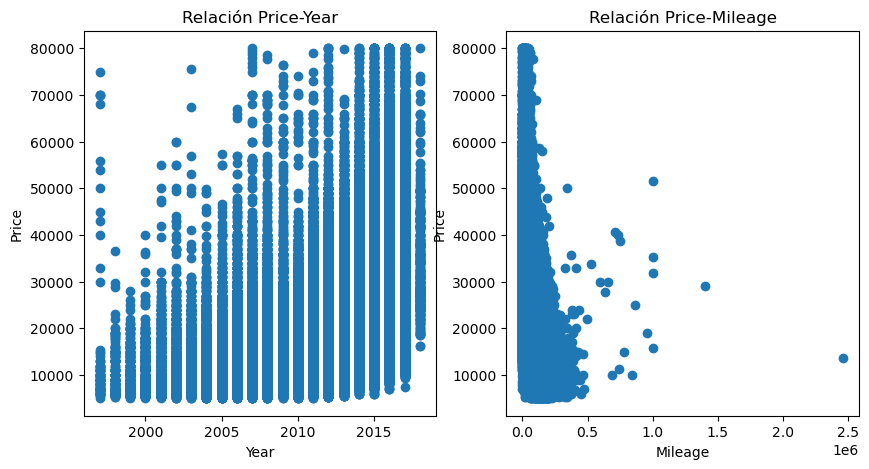

In [10]:
# Para facilitar la visualización de los datos candidatos a entrenar el modelo unicamente representaremos los
# puntos 'Price'vs'Year' y 'Price' vs 'Mileage'

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Gráfico 1: Year vs Price
axs[0].scatter(dataTraining['Year'], dataTraining['Price'])
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Price')
axs[0].set_title("Relación Price-Year")

# Gráfico 2: Mileage vs Price
axs[1].scatter(dataTraining['Mileage'], dataTraining['Price'])
axs[1].set_xlabel('Mileage')
axs[1].set_ylabel('Price')
axs[1].set_title("Relación Price-Mileage")

plt.show()

En lo anterior podemos observar un comportamiento interesante en el precio de los vehiculos. Muy acorde al caso real o cotidiano que intuitivamente podriamos entender sobre el mercado de vehiculos. 

- Entre mas nuevo es un vehiculo su precio tiende a incrementar, mientras que entre más antiguo o viejo su precio disminuye. Existen algunos datos atipicos sobre los vehiculos antiguos que podrian representar tal vez vehiculos de colección.

- Entre menor sea el valor de 'Mileage' el precio del vehiculo tiende a incrementar.

### Modelado con Ensambles

### Random Forest:

In [11]:
# Separamos Variables regresoras y Variable a predecir:
X = dataTraining.drop('Price', axis=1)
y = dataTraining['Price']

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [12]:
# Entrenamiento del Modelo
reg_RF = RandomForestRegressor(n_estimators=100, random_state=42)
reg_RF.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
y_pred_reg_RF = reg_RF.predict(X_test)

# Variance_score
print("Varianza: %.3f" % (explained_variance_score(y_pred_reg_RF, y_test)))

# RMSE
rmse_reg_RF = np.sqrt(mean_squared_error(y_test, y_pred_reg_RF))
print("RMSE: %.3f" % rmse_reg_RF)

# MAE
mae_reg_RF = mean_absolute_error(y_test, y_pred_reg_RF)
print('MAE: %.3f' % mae_reg_RF)

rms_reg_RF = mean_squared_error(y_test, y_pred_reg_RF, squared=False)
print(f"RMS de Random Forest: {rms_reg_RF}")

Varianza: 0.865
RMSE: 3790.128
MAE: 2349.486
RMS de Random Forest: 3790.1278768807815


### Disponibilización del Modelo

Para poder disponibilizar el modelo debemos crear el archivo binario .pkl que posteriormente cargaremos en nuestro script de python.

In [16]:
# Exportar modelo a archivo binario .pkl se puede ajustar el compress en valores mas altos 
# para que el archivo sea mas pequeño.
import joblib
joblib.dump(reg_RF, 'price_vehicle_reg_s.pkl', compress=3)

['price_vehicle_reg3.pkl']

In [27]:
# Importar modelo desde archivo binario .pkl
import joblib
reg = joblib.load('/Users/gabrielbga/Downloads/carga/price_vehicle_reg_s.pkl') 

A continuación presentamos las dos formas de disponibilizar el modelo:

### Ejecución Local de modelo:

In [28]:
# Importación librerías
from flask import Flask
from flask_restx import Api, Resource, fields

In [29]:
app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Predictor of Vehicle Prices API',
    description='El "Predictor of Vehicle Prices API" es un modelo disponible para predecir precios de vehiculos.')

ns = api.namespace('predict', 
     description='Vehicle Price Regressor')
   
parser = api.parser()

# Parametros de la API
parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Year of the Vehicle', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=int, 
    required=True, 
    help='Mileage of the Vehicle', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='State of the Vehicle', 
    location='args')

parser.add_argument(
    'Make', 
    type=str, 
    required=True, 
    help='Make of the Vehicle', 
    location='args')

parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Model of the Vehicle', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

In [33]:
# Forma de Input que entiende el modelo regresor:
shape_input = ['Year','Mileage','State_AK','State_AL','State_AR','State_AZ','State_CA','State_CO','State_CT','State_DE','State_FL','State_GA','State_HI','State_IA','State_ID','State_IL','State_IN','State_KS','State_KY','State_LA','State_MA','State_MD','State_ME','State_MI','State_MN','State_MO','State_MS','State_MT','State_NC','State_ND','State_NE','State_NH','State_NJ','State_NM','State_NV','State_NY','State_OH','State_OK','State_OR','State_PA','State_RI','State_SC','State_SD','State_TN','State_TX','State_UT','State_VA','State_VT','State_WA','State_WI','State_WV','State_WY','Make_Acura','Make_Audi','Make_BMW','Make_Bentley','Make_Buick','Make_Cadillac','Make_Chevrolet','Make_Chrysler','Make_Dodge','Make_FIAT','Make_Ford','Make_GMC','Make_Honda','Make_Hyundai','Make_INFINITI','Make_Jaguar','Make_Jeep','Make_Kia','Make_Land','Make_Lexus','Make_Lincoln','Make_MINI','Make_Mazda','Make_Mercedes-Benz','Make_Mercury','Make_Mitsubishi','Make_Nissan','Make_Pontiac','Make_Porsche','Make_Ram','Make_Scion','Make_Subaru','Make_Suzuki','Make_Tesla','Make_Toyota','Make_Volkswagen','Make_Volvo','Model_1','Model_15002WD','Model_15004WD','Model_1500Laramie','Model_1500Tradesman','Model_200LX','Model_200Limited','Model_200S','Model_200Touring','Model_25002WD','Model_25004WD','Model_3','Model_300300C','Model_300300S','Model_3004dr','Model_300Base','Model_300Limited','Model_300Touring','Model_35004WD','Model_350Z2dr','Model_4Runner2WD','Model_4Runner4WD','Model_4Runner4dr','Model_4RunnerLimited','Model_4RunnerRWD','Model_4RunnerSR5','Model_4RunnerTrail','Model_5','Model_500Pop','Model_6','Model_7','Model_911','Model_9112dr','Model_A34dr','Model_A44dr','Model_A64dr','Model_A8','Model_AcadiaAWD','Model_AcadiaFWD','Model_Accent4dr','Model_Accord','Model_AccordEX','Model_AccordEX-L','Model_AccordLX','Model_AccordLX-S','Model_AccordSE','Model_Altima4dr','Model_Armada2WD','Model_Armada4WD','Model_Avalanche2WD','Model_Avalanche4WD','Model_Avalon4dr','Model_AvalonLimited','Model_AvalonTouring','Model_AvalonXLE','Model_Azera4dr','Model_Boxster2dr','Model_C-Class4dr','Model_C-ClassC','Model_C-ClassC300','Model_C-ClassC350','Model_C702dr','Model_CC4dr','Model_CR-V2WD','Model_CR-V4WD','Model_CR-VEX','Model_CR-VEX-L','Model_CR-VLX','Model_CR-VSE','Model_CR-ZEX','Model_CT','Model_CTCT','Model_CTS','Model_CTS-V','Model_CTS4dr','Model_CX-7FWD','Model_CX-9AWD','Model_CX-9FWD','Model_CX-9Grand','Model_CX-9Touring','Model_Caliber4dr','Model_Camaro2dr','Model_CamaroConvertible','Model_CamaroCoupe','Model_Camry','Model_Camry4dr','Model_CamryBase','Model_CamryL','Model_CamryLE','Model_CamrySE','Model_CamryXLE','Model_Canyon2WD','Model_Canyon4WD','Model_CanyonCrew','Model_CanyonExtended','Model_CayenneAWD','Model_Cayman2dr','Model_Challenger2dr','Model_ChallengerR/T','Model_Charger4dr','Model_ChargerSE','Model_ChargerSXT','Model_CherokeeLimited','Model_CherokeeSport','Model_Civic','Model_CivicEX','Model_CivicEX-L','Model_CivicLX','Model_CivicSi','Model_Cobalt2dr','Model_Cobalt4dr','Model_Colorado2WD','Model_Colorado4WD','Model_ColoradoCrew','Model_ColoradoExtended','Model_Compass4WD','Model_CompassLatitude','Model_CompassLimited','Model_CompassSport','Model_Continental','Model_Cooper','Model_Corolla4dr','Model_CorollaL','Model_CorollaLE','Model_CorollaS','Model_Corvette2dr','Model_CorvetteConvertible','Model_CorvetteCoupe','Model_CruzeLT','Model_CruzeSedan','Model_DTS4dr','Model_Dakota2WD','Model_Dakota4WD','Model_Durango2WD','Model_Durango4dr','Model_DurangoAWD','Model_DurangoSXT','Model_E-ClassE','Model_E-ClassE320','Model_E-ClassE350','Model_ES','Model_ESES','Model_Eclipse3dr','Model_Econoline','Model_EdgeLimited','Model_EdgeSE','Model_EdgeSEL','Model_EdgeSport','Model_Elantra','Model_Elantra4dr','Model_ElantraLimited','Model_Element2WD','Model_Element4WD','Model_EnclaveConvenience','Model_EnclaveLeather','Model_EnclavePremium','Model_Eos2dr','Model_EquinoxAWD','Model_EquinoxFWD','Model_Escalade','Model_Escalade2WD','Model_Escalade4dr','Model_EscaladeAWD','Model_Escape4WD','Model_Escape4dr','Model_EscapeFWD','Model_EscapeLImited','Model_EscapeLimited','Model_EscapeS','Model_EscapeSE','Model_EscapeXLT','"Model_Excursion137"""','Model_Expedition','Model_Expedition2WD','Model_Expedition4WD','Model_ExpeditionLimited','Model_ExpeditionXLT','Model_Explorer','Model_Explorer4WD','Model_Explorer4dr','Model_ExplorerBase','Model_ExplorerEddie','Model_ExplorerFWD','Model_ExplorerLimited','Model_ExplorerXLT','Model_Express','Model_F-1502WD','Model_F-1504WD','Model_F-150FX2','Model_F-150FX4','Model_F-150King','Model_F-150Lariat','Model_F-150Limited','Model_F-150Platinum','Model_F-150STX','Model_F-150SuperCrew','Model_F-150XL','Model_F-150XLT','Model_F-250King','Model_F-250Lariat','Model_F-250XL','Model_F-250XLT','Model_F-350King','Model_F-350Lariat','Model_F-350XL','Model_F-350XLT','Model_FJ','Model_FX35AWD','Model_FiestaS','Model_FiestaSE','Model_FitSport','Model_FlexLimited','Model_FlexSE','Model_FlexSEL','Model_Focus4dr','Model_Focus5dr','Model_FocusS','Model_FocusSE','Model_FocusSEL','Model_FocusST','Model_FocusTitanium','Model_Forester2.5X','Model_Forester4dr','Model_Forte','Model_ForteEX','Model_ForteLX','Model_ForteSX','Model_Frontier','Model_Frontier2WD','Model_Frontier4WD','Model_Fusion4dr','Model_FusionHybrid','Model_FusionS','Model_FusionSE','Model_FusionSEL','Model_G35','Model_G37','Model_G64dr','Model_GLI4dr','Model_GS','Model_GSGS','Model_GTI2dr','Model_GTI4dr','Model_GX','Model_GXGX','Model_Galant4dr','Model_Genesis','Model_Golf','Model_Grand','Model_Highlander','Model_Highlander4WD','Model_Highlander4dr','Model_HighlanderBase','Model_HighlanderFWD','Model_HighlanderLimited','Model_HighlanderSE','Model_IS','Model_ISIS','Model_Impala4dr','Model_ImpalaLS','Model_ImpalaLT','Model_Impreza','Model_Impreza2.0i','Model_ImprezaSport','Model_Jetta','Model_JourneyAWD','Model_JourneyFWD','Model_JourneySXT','Model_LS','Model_LSLS','Model_LX','Model_LXLX','Model_LaCrosse4dr','Model_LaCrosseAWD','Model_LaCrosseFWD','Model_Lancer4dr','Model_Land','Model_Legacy','Model_Legacy2.5i','Model_Legacy3.6R','Model_Liberty4WD','Model_LibertyLimited','Model_LibertySport','Model_Lucerne4dr','Model_M-ClassML350','Model_MDX4WD','Model_MDXAWD','Model_MKXAWD','Model_MKXFWD','Model_MKZ4dr','Model_MX5','Model_Malibu','Model_Malibu1LT','Model_Malibu4dr','Model_MalibuLS','Model_MalibuLT','Model_Matrix5dr','Model_Maxima4dr','Model_Mazda34dr','Model_Mazda35dr','Model_Mazda64dr','Model_Milan4dr','Model_Model','Model_Monte','Model_Murano2WD','Model_MuranoAWD','Model_MuranoS','Model_Mustang2dr','Model_MustangBase','Model_MustangDeluxe','Model_MustangGT','Model_MustangPremium','Model_MustangShelby','Model_Navigator','Model_Navigator2WD','Model_Navigator4WD','Model_Navigator4dr','Model_New','Model_OdysseyEX','Model_OdysseyEX-L','Model_OdysseyLX','Model_OdysseyTouring','Model_Optima4dr','Model_OptimaEX','Model_OptimaLX','Model_OptimaSX','Model_Outback2.5i','Model_Outback3.6R','Model_Outlander','Model_Outlander2WD','Model_Outlander4WD','Model_PT','Model_PacificaLimited','Model_PacificaTouring','Model_Passat','Model_Passat4dr','Model_Pathfinder2WD','Model_Pathfinder4WD','Model_PathfinderS','Model_PathfinderSE','Model_Patriot4WD','Model_PatriotLatitude','Model_PatriotLimited','Model_PatriotSport','Model_Pilot2WD','Model_Pilot4WD','Model_PilotEX','Model_PilotEX-L','Model_PilotLX','Model_PilotSE','Model_PilotTouring','Model_Prius','Model_Prius5dr','Model_PriusBase','Model_PriusFive','Model_PriusFour','Model_PriusOne','Model_PriusThree','Model_PriusTwo','Model_Q5quattro','Model_Q7quattro','Model_QX562WD','Model_QX564WD','Model_Quest4dr','Model_RAV4','Model_RAV44WD','Model_RAV44dr','Model_RAV4Base','Model_RAV4FWD','Model_RAV4LE','Model_RAV4Limited','Model_RAV4Sport','Model_RAV4XLE','Model_RDXAWD','Model_RDXFWD','Model_RX','Model_RX-84dr','Model_RXRX','Model_Ram','Model_Ranger2WD','Model_Ranger4WD','Model_RangerSuperCab','Model_Regal4dr','Model_RegalGS','Model_RegalPremium','Model_RegalTurbo','Model_RidgelineRTL','Model_RidgelineSport','Model_RioLX','Model_RogueFWD','Model_Rover','Model_S2000Manual','Model_S44dr','Model_S60T5','Model_S804dr','Model_SC','Model_SL-ClassSL500','Model_SLK-ClassSLK350','Model_SRXLuxury','Model_STS4dr','Model_Santa','Model_Savana','Model_Sedona4dr','Model_SedonaEX','Model_SedonaLX','Model_Sentra4dr','Model_Sequoia4WD','Model_Sequoia4dr','Model_SequoiaLimited','Model_SequoiaPlatinum','Model_SequoiaSR5','Model_Sienna5dr','Model_SiennaLE','Model_SiennaLimited','Model_SiennaSE','Model_SiennaXLE','Model_Sierra','Model_Silverado','Model_Sonata4dr','Model_SonataLimited','Model_SonataSE','Model_SonicHatch','Model_SonicSedan','Model_Sorento2WD','Model_SorentoEX','Model_SorentoLX','Model_SorentoSX','Model_Soul+','Model_SoulBase','Model_Sportage2WD','Model_SportageAWD','Model_SportageEX','Model_SportageLX','Model_SportageSX','Model_Sprinter','Model_Suburban2WD','Model_Suburban4WD','Model_Suburban4dr','Model_Super','Model_TL4dr','Model_TLAutomatic','Model_TSXAutomatic','Model_TT2dr','Model_Tacoma2WD','Model_Tacoma4WD','Model_TacomaBase','Model_TacomaPreRunner','Model_Tahoe2WD','Model_Tahoe4WD','Model_Tahoe4dr','Model_TahoeLS','Model_TahoeLT','Model_Taurus4dr','Model_TaurusLimited','Model_TaurusSE','Model_TaurusSEL','Model_TaurusSHO','Model_TerrainAWD','Model_TerrainFWD','Model_Tiguan2WD','Model_TiguanS','Model_TiguanSE','Model_TiguanSEL','Model_Titan','Model_Titan2WD','Model_Titan4WD','Model_Touareg4dr','Model_Town','Model_Transit','Model_TraverseAWD','Model_TraverseFWD','Model_TucsonAWD','Model_TucsonFWD','Model_TucsonLimited','Model_Tundra','Model_Tundra2WD','Model_Tundra4WD','Model_TundraBase','Model_TundraLimited','Model_TundraSR5','Model_VeracruzAWD','Model_VeracruzFWD','Model_Versa4dr','Model_Versa5dr','Model_Vibe4dr','Model_WRXBase','Model_WRXLimited','Model_WRXPremium','Model_WRXSTI','Model_Wrangler','Model_Wrangler2dr','Model_Wrangler4WD','Model_WranglerRubicon','Model_WranglerSahara','Model_WranglerSport','Model_WranglerX','Model_X1xDrive28i','Model_X3AWD','Model_X3xDrive28i',
               'Model_X5AWD','Model_X5xDrive35i','Model_XC60AWD','Model_XC60FWD','Model_XC60T6','Model_XC704dr','Model_XC90AWD','Model_XC90FWD','Model_XC90T6','Model_XF4dr','Model_XJ4dr','Model_XK2dr','Model_Xterra2WD','Model_Xterra4WD','Model_Xterra4dr','Model_Yaris','Model_Yaris4dr','Model_YarisBase','Model_YarisLE','Model_Yukon','Model_Yukon2WD','Model_Yukon4WD','Model_Yukon4dr','Model_tC2dr','Model_xB5dr','Model_xD5dr']

shape_input = pd.DataFrame({col: [0] for col in shape_input})

# Tomamos la entrada del usuario y la modelamos a la forma en que el modelo entiende
def transform_to_model(rawData):
    data = rawData.copy()
    for col in shape_input.columns:
        if (col not in data.columns):
            data[col] = 0
    return data[shape_input.columns]

# Metodo que utiliza la entrada del usuario para predecir el resultado utilizando el modelo
def predict_price(year, mileage, state, make, model):

    #reg = joblib.load(os.path.dirname(__file__) + '/price_vehicle_reg.pkl') 
    #reg = joblib.load('/Users/gabrielbga/Downloads/carga/price_vehicle_reg.pkl') 

    # Input Crudo
    raw_x = pd.DataFrame([[year, mileage, state, make, model]], 
                        columns=['Year', 'Mileage', 'State', 'Make', 'Model'])

    x_clean = raw_x.copy()
    
    # Limpiando datos
    x_clean['State'] = x_clean['State'].str.strip()
    x_clean['Make'] = x_clean['Make'].str.strip()
    x_clean['Model'] = x_clean['Model'].str.strip()
    
    # Create features and Modeling Input
    x_clean = pd.get_dummies(x_clean, drop_first=False, dummy_na=False) # Ignoramos los valores NaN
    x_shaped = transform_to_model(x_clean.copy())
    
    # Make prediction
    p1 = reg.predict(x_shaped)

    return p1


In [34]:
@ns.route('/')
class PredictApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": predict_price(args['Year'], args['Mileage'], args['State'], args['Make'], args['Model'])
        }, 200

In [36]:
# Ejecución de la aplicación que disponibiliza el modelo de manera local en el puerto 5001 (o el que tenga disponible)
app.run(debug=True, use_reloader=False, host='0.0.0.0', port=5001)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5001
 * Running on http://192.168.10.20:5001
Press CTRL+C to quit
127.0.0.1 - - [29/Apr/2023 19:55:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2023 19:55:45] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [29/Apr/2023 19:55:45] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [29/Apr/2023 19:55:45] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [29/Apr/2023 19:55:45] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [29/Apr/2023 19:55:45] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [29/Apr/2023 19:56:03] "GET /predict/?Year=2015&Mileage=20578&State=OH&Make=Chevrolet&Model=Tahoe4WD HTTP/1.1" 200 -


In [35]:
# Test del modelo utilizado en la api local
predict_price(2018, 20578, '  OH', '  Chevrolet  ', '  Tahoe4WD  ')
#37895	2015	20578	OH	Chevrolet	Tahoe4WD

array([53894.63])

### Ejecución Remota de modelo:
### Script en Python para Desplegar Api en Flask (_api.py_)

In [ ]:
#!/usr/bin/python
from flask import Flask
from flask_restx import Api, Resource, fields
import joblib
from model_deployment import predict_price

app = Flask(__name__)

api = Api(
    app, 
    version='1.0', 
    title='Predictor of Vehicle Prices API',
    description='El "Predictor of Vehicle Prices API" es un modelo disponible para predecir precios de vehiculos.')

ns = api.namespace('Forecaster', 
     description='Vehicle Price Forecaster API')
   
parser = api.parser()

# Parametros de la API
parser.add_argument(
    'Year', 
    type=int, 
    required=True, 
    help='Year of the Vehicle', 
    location='args')

parser.add_argument(
    'Mileage', 
    type=int, 
    required=True, 
    help='Mileage of the Vehicle', 
    location='args')

parser.add_argument(
    'State', 
    type=str, 
    required=True, 
    help='State of the Vehicle', 
    location='args')

parser.add_argument(
    'Make', 
    type=str, 
    required=True, 
    help='Make of the Vehicle', 
    location='args')

parser.add_argument(
    'Model', 
    type=str, 
    required=True, 
    help='Model of the Vehicle', 
    location='args')

resource_fields = api.model('Resource', {
    'result': fields.String,
})

@ns.route('/')
class PredictApi(Resource):

    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    def get(self):
        args = parser.parse_args()
        
        return {
         "result": predict_price(args['Year'], args['Mileage'], args['State'], args['Make'], args['Model'])
        }, 200
    
    
if __name__ == '__main__':
    app.run(debug=True, use_reloader=False, host='0.0.0.0', port=8888)

### Script en Python de libreria Model Deployment (_model_deployment.py_)

In [ ]:
#!/usr/bin/python

import pandas as pd
import joblib
import sys
import os

# Forma de Input que entiende el modelo regresor:
# Forma de Input que entiende el modelo regresor:
shape_input = ['Year','Mileage','State_AK','State_AL','State_AR','State_AZ','State_CA','State_CO','State_CT','State_DE','State_FL','State_GA','State_HI','State_IA','State_ID','State_IL','State_IN','State_KS','State_KY','State_LA','State_MA','State_MD','State_ME','State_MI','State_MN','State_MO','State_MS','State_MT','State_NC','State_ND','State_NE','State_NH','State_NJ','State_NM','State_NV','State_NY','State_OH','State_OK','State_OR','State_PA','State_RI','State_SC','State_SD','State_TN','State_TX','State_UT','State_VA','State_VT','State_WA','State_WI','State_WV','State_WY','Make_Acura','Make_Audi','Make_BMW','Make_Bentley','Make_Buick','Make_Cadillac','Make_Chevrolet','Make_Chrysler','Make_Dodge','Make_FIAT','Make_Ford','Make_GMC','Make_Honda','Make_Hyundai','Make_INFINITI','Make_Jaguar','Make_Jeep','Make_Kia','Make_Land','Make_Lexus','Make_Lincoln','Make_MINI','Make_Mazda','Make_Mercedes-Benz','Make_Mercury','Make_Mitsubishi','Make_Nissan','Make_Pontiac','Make_Porsche','Make_Ram','Make_Scion','Make_Subaru','Make_Suzuki','Make_Tesla','Make_Toyota','Make_Volkswagen','Make_Volvo','Model_1','Model_15002WD','Model_15004WD','Model_1500Laramie','Model_1500Tradesman','Model_200LX','Model_200Limited','Model_200S','Model_200Touring','Model_25002WD','Model_25004WD','Model_3','Model_300300C','Model_300300S','Model_3004dr','Model_300Base','Model_300Limited','Model_300Touring','Model_35004WD','Model_350Z2dr','Model_4Runner2WD','Model_4Runner4WD','Model_4Runner4dr','Model_4RunnerLimited','Model_4RunnerRWD','Model_4RunnerSR5','Model_4RunnerTrail','Model_5','Model_500Pop','Model_6','Model_7','Model_911','Model_9112dr','Model_A34dr','Model_A44dr','Model_A64dr','Model_A8','Model_AcadiaAWD','Model_AcadiaFWD','Model_Accent4dr','Model_Accord','Model_AccordEX','Model_AccordEX-L','Model_AccordLX','Model_AccordLX-S','Model_AccordSE','Model_Altima4dr','Model_Armada2WD','Model_Armada4WD','Model_Avalanche2WD','Model_Avalanche4WD','Model_Avalon4dr','Model_AvalonLimited','Model_AvalonTouring','Model_AvalonXLE','Model_Azera4dr','Model_Boxster2dr','Model_C-Class4dr','Model_C-ClassC','Model_C-ClassC300','Model_C-ClassC350','Model_C702dr','Model_CC4dr','Model_CR-V2WD','Model_CR-V4WD','Model_CR-VEX','Model_CR-VEX-L','Model_CR-VLX','Model_CR-VSE','Model_CR-ZEX','Model_CT','Model_CTCT','Model_CTS','Model_CTS-V','Model_CTS4dr','Model_CX-7FWD','Model_CX-9AWD','Model_CX-9FWD','Model_CX-9Grand','Model_CX-9Touring','Model_Caliber4dr','Model_Camaro2dr','Model_CamaroConvertible','Model_CamaroCoupe','Model_Camry','Model_Camry4dr','Model_CamryBase','Model_CamryL','Model_CamryLE','Model_CamrySE','Model_CamryXLE','Model_Canyon2WD','Model_Canyon4WD','Model_CanyonCrew','Model_CanyonExtended','Model_CayenneAWD','Model_Cayman2dr','Model_Challenger2dr','Model_ChallengerR/T','Model_Charger4dr','Model_ChargerSE','Model_ChargerSXT','Model_CherokeeLimited','Model_CherokeeSport','Model_Civic','Model_CivicEX','Model_CivicEX-L','Model_CivicLX','Model_CivicSi','Model_Cobalt2dr','Model_Cobalt4dr','Model_Colorado2WD','Model_Colorado4WD','Model_ColoradoCrew','Model_ColoradoExtended','Model_Compass4WD','Model_CompassLatitude','Model_CompassLimited','Model_CompassSport','Model_Continental','Model_Cooper','Model_Corolla4dr','Model_CorollaL','Model_CorollaLE','Model_CorollaS','Model_Corvette2dr','Model_CorvetteConvertible','Model_CorvetteCoupe','Model_CruzeLT','Model_CruzeSedan','Model_DTS4dr','Model_Dakota2WD','Model_Dakota4WD','Model_Durango2WD','Model_Durango4dr','Model_DurangoAWD','Model_DurangoSXT','Model_E-ClassE','Model_E-ClassE320','Model_E-ClassE350','Model_ES','Model_ESES','Model_Eclipse3dr','Model_Econoline','Model_EdgeLimited','Model_EdgeSE','Model_EdgeSEL','Model_EdgeSport','Model_Elantra','Model_Elantra4dr','Model_ElantraLimited','Model_Element2WD','Model_Element4WD','Model_EnclaveConvenience','Model_EnclaveLeather','Model_EnclavePremium','Model_Eos2dr','Model_EquinoxAWD','Model_EquinoxFWD','Model_Escalade','Model_Escalade2WD','Model_Escalade4dr','Model_EscaladeAWD','Model_Escape4WD','Model_Escape4dr','Model_EscapeFWD','Model_EscapeLImited','Model_EscapeLimited','Model_EscapeS','Model_EscapeSE','Model_EscapeXLT','"Model_Excursion137"""','Model_Expedition','Model_Expedition2WD','Model_Expedition4WD','Model_ExpeditionLimited','Model_ExpeditionXLT','Model_Explorer','Model_Explorer4WD','Model_Explorer4dr','Model_ExplorerBase','Model_ExplorerEddie','Model_ExplorerFWD','Model_ExplorerLimited','Model_ExplorerXLT','Model_Express','Model_F-1502WD','Model_F-1504WD','Model_F-150FX2','Model_F-150FX4','Model_F-150King','Model_F-150Lariat','Model_F-150Limited','Model_F-150Platinum','Model_F-150STX','Model_F-150SuperCrew','Model_F-150XL','Model_F-150XLT','Model_F-250King','Model_F-250Lariat','Model_F-250XL','Model_F-250XLT','Model_F-350King','Model_F-350Lariat','Model_F-350XL','Model_F-350XLT','Model_FJ','Model_FX35AWD','Model_FiestaS','Model_FiestaSE','Model_FitSport','Model_FlexLimited','Model_FlexSE','Model_FlexSEL','Model_Focus4dr','Model_Focus5dr','Model_FocusS','Model_FocusSE','Model_FocusSEL','Model_FocusST','Model_FocusTitanium','Model_Forester2.5X','Model_Forester4dr','Model_Forte','Model_ForteEX','Model_ForteLX','Model_ForteSX','Model_Frontier','Model_Frontier2WD','Model_Frontier4WD','Model_Fusion4dr','Model_FusionHybrid','Model_FusionS','Model_FusionSE','Model_FusionSEL','Model_G35','Model_G37','Model_G64dr','Model_GLI4dr','Model_GS','Model_GSGS','Model_GTI2dr','Model_GTI4dr','Model_GX','Model_GXGX','Model_Galant4dr','Model_Genesis','Model_Golf','Model_Grand','Model_Highlander','Model_Highlander4WD','Model_Highlander4dr','Model_HighlanderBase','Model_HighlanderFWD','Model_HighlanderLimited','Model_HighlanderSE','Model_IS','Model_ISIS','Model_Impala4dr','Model_ImpalaLS','Model_ImpalaLT','Model_Impreza','Model_Impreza2.0i','Model_ImprezaSport','Model_Jetta','Model_JourneyAWD','Model_JourneyFWD','Model_JourneySXT','Model_LS','Model_LSLS','Model_LX','Model_LXLX','Model_LaCrosse4dr','Model_LaCrosseAWD','Model_LaCrosseFWD','Model_Lancer4dr','Model_Land','Model_Legacy','Model_Legacy2.5i','Model_Legacy3.6R','Model_Liberty4WD','Model_LibertyLimited','Model_LibertySport','Model_Lucerne4dr','Model_M-ClassML350','Model_MDX4WD','Model_MDXAWD','Model_MKXAWD','Model_MKXFWD','Model_MKZ4dr','Model_MX5','Model_Malibu','Model_Malibu1LT','Model_Malibu4dr','Model_MalibuLS','Model_MalibuLT','Model_Matrix5dr','Model_Maxima4dr','Model_Mazda34dr','Model_Mazda35dr','Model_Mazda64dr','Model_Milan4dr','Model_Model','Model_Monte','Model_Murano2WD','Model_MuranoAWD','Model_MuranoS','Model_Mustang2dr','Model_MustangBase','Model_MustangDeluxe','Model_MustangGT','Model_MustangPremium','Model_MustangShelby','Model_Navigator','Model_Navigator2WD','Model_Navigator4WD','Model_Navigator4dr','Model_New','Model_OdysseyEX','Model_OdysseyEX-L','Model_OdysseyLX','Model_OdysseyTouring','Model_Optima4dr','Model_OptimaEX','Model_OptimaLX','Model_OptimaSX','Model_Outback2.5i','Model_Outback3.6R','Model_Outlander','Model_Outlander2WD','Model_Outlander4WD','Model_PT','Model_PacificaLimited','Model_PacificaTouring','Model_Passat','Model_Passat4dr','Model_Pathfinder2WD','Model_Pathfinder4WD','Model_PathfinderS','Model_PathfinderSE','Model_Patriot4WD','Model_PatriotLatitude','Model_PatriotLimited','Model_PatriotSport','Model_Pilot2WD','Model_Pilot4WD','Model_PilotEX','Model_PilotEX-L','Model_PilotLX','Model_PilotSE','Model_PilotTouring','Model_Prius','Model_Prius5dr','Model_PriusBase','Model_PriusFive','Model_PriusFour','Model_PriusOne','Model_PriusThree','Model_PriusTwo','Model_Q5quattro','Model_Q7quattro','Model_QX562WD','Model_QX564WD','Model_Quest4dr','Model_RAV4','Model_RAV44WD','Model_RAV44dr','Model_RAV4Base','Model_RAV4FWD','Model_RAV4LE','Model_RAV4Limited','Model_RAV4Sport','Model_RAV4XLE','Model_RDXAWD','Model_RDXFWD','Model_RX','Model_RX-84dr','Model_RXRX','Model_Ram','Model_Ranger2WD','Model_Ranger4WD','Model_RangerSuperCab','Model_Regal4dr','Model_RegalGS','Model_RegalPremium','Model_RegalTurbo','Model_RidgelineRTL','Model_RidgelineSport','Model_RioLX','Model_RogueFWD','Model_Rover','Model_S2000Manual','Model_S44dr','Model_S60T5','Model_S804dr','Model_SC','Model_SL-ClassSL500','Model_SLK-ClassSLK350','Model_SRXLuxury','Model_STS4dr','Model_Santa','Model_Savana','Model_Sedona4dr','Model_SedonaEX','Model_SedonaLX','Model_Sentra4dr','Model_Sequoia4WD','Model_Sequoia4dr','Model_SequoiaLimited','Model_SequoiaPlatinum','Model_SequoiaSR5','Model_Sienna5dr','Model_SiennaLE','Model_SiennaLimited','Model_SiennaSE','Model_SiennaXLE','Model_Sierra','Model_Silverado','Model_Sonata4dr','Model_SonataLimited','Model_SonataSE','Model_SonicHatch','Model_SonicSedan','Model_Sorento2WD','Model_SorentoEX','Model_SorentoLX','Model_SorentoSX','Model_Soul+','Model_SoulBase','Model_Sportage2WD','Model_SportageAWD','Model_SportageEX','Model_SportageLX','Model_SportageSX','Model_Sprinter','Model_Suburban2WD','Model_Suburban4WD','Model_Suburban4dr','Model_Super','Model_TL4dr','Model_TLAutomatic','Model_TSXAutomatic','Model_TT2dr','Model_Tacoma2WD','Model_Tacoma4WD','Model_TacomaBase','Model_TacomaPreRunner','Model_Tahoe2WD','Model_Tahoe4WD','Model_Tahoe4dr','Model_TahoeLS','Model_TahoeLT','Model_Taurus4dr','Model_TaurusLimited','Model_TaurusSE','Model_TaurusSEL','Model_TaurusSHO','Model_TerrainAWD','Model_TerrainFWD','Model_Tiguan2WD','Model_TiguanS','Model_TiguanSE','Model_TiguanSEL','Model_Titan','Model_Titan2WD','Model_Titan4WD','Model_Touareg4dr','Model_Town','Model_Transit','Model_TraverseAWD','Model_TraverseFWD','Model_TucsonAWD','Model_TucsonFWD','Model_TucsonLimited','Model_Tundra','Model_Tundra2WD','Model_Tundra4WD','Model_TundraBase','Model_TundraLimited','Model_TundraSR5','Model_VeracruzAWD','Model_VeracruzFWD','Model_Versa4dr','Model_Versa5dr','Model_Vibe4dr','Model_WRXBase','Model_WRXLimited','Model_WRXPremium','Model_WRXSTI','Model_Wrangler','Model_Wrangler2dr','Model_Wrangler4WD','Model_WranglerRubicon','Model_WranglerSahara','Model_WranglerSport','Model_WranglerX','Model_X1xDrive28i','Model_X3AWD','Model_X3xDrive28i',
               'Model_X5AWD','Model_X5xDrive35i','Model_XC60AWD','Model_XC60FWD','Model_XC60T6','Model_XC704dr','Model_XC90AWD','Model_XC90FWD','Model_XC90T6','Model_XF4dr','Model_XJ4dr','Model_XK2dr','Model_Xterra2WD','Model_Xterra4WD','Model_Xterra4dr','Model_Yaris','Model_Yaris4dr','Model_YarisBase','Model_YarisLE','Model_Yukon','Model_Yukon2WD','Model_Yukon4WD','Model_Yukon4dr','Model_tC2dr','Model_xB5dr','Model_xD5dr']

shape_input = pd.DataFrame({col: [0] for col in shape_input})

def transform_to_model(rawData):
    data = rawData.copy()
    for col in shape_input.columns:
        if (col not in data.columns):
            data[col] = 0
    return data[shape_input.columns]

def predict_price(year, mileage, state, make, model):

    reg = joblib.load(os.path.dirname(__file__) + '/price_vehicle_reg_s.pkl') 

    # Input Crudo
    raw_x = pd.DataFrame([[year, mileage, state, make, model]], 
                        columns=['Year', 'Mileage', 'State', 'Make', 'Model'])

    x_clean = raw_x.copy()
    
    # Limpiando datos
    x_clean['State'] = x_clean['State'].str.strip()
    x_clean['Make'] = x_clean['Make'].str.strip()
    x_clean['Model'] = x_clean['Model'].str.strip()
    
    # Create features and Modeling Input
    x_clean = pd.get_dummies(x_clean, drop_first=False, dummy_na=False) # Ignoramos los valores NaN
    x_shaped = transform_to_model(x_clean.copy())
    
    # Make prediction
    p1 = reg.predict(x_shaped)

    return p1


if __name__ == "__main__":
    
    if len(sys.argv) == 1:
        print('Please add the correct vehicle features: Year, Mileage, State, Make and Model.')
        
    else:

        year = sys.argv[1]
        mileage = sys.argv[2]
        state = sys.argv[3]
        make = sys.argv[4]
        model = sys.argv[5]

        p1 = predict_price(year, mileage, state, make, model)
        
        print('Price of Vehicle: ', p1)

### Probando modelo disponible a través de API en un EC2 en AWS

Una vez desplegado el servicio de EC2 en AWS y cargado los scripts presentados anteriormente y el archivo binario .pkl del modelo entrenado procedemos a hacer un par de pruebas con la API, utilizando el DNS publico de la instancia y llamandolo por medio de comandos python para obtener una respuesta tipo JSON e imprimirla.

Realizaremos dos pruebas para demostrar la proyección del precio de un vehiculo del año 2015 y otro igual pero del 2022. Observaremos que el modelo asigna un valor mas bajo al vehiculo más antiguo.

In [5]:
#!pip install requests

In [7]:
import requests

# Primera prueba con un Vehiculo Chevrolet del año 2015
url = 'http://ec2-54-71-163-1.us-west-2.compute.amazonaws.com:8888//Forecaster/?Year=2015&Mileage=20578&State=OH&Make=Chevrolet&Model=Tahoe4WD'  # URL del endpoint

response = requests.get(url)  # Realiza la solicitud GET

if response.status_code == 200:  # Verifica si la respuesta es exitosa (código 200)
    data = response.json()  # Obtén el JSON de la respuesta
    print(data)  # Imprime el JSON
else:
    print(f'Error al realizar la solicitud: {response.status_code}')

{'result': '[47405.55]'}


Podemos observar que para un Vehiculo **Chevrolet Tahoe4WD** del año **2015** con un Kilometraje de **20578** Millas el valor asignado por el modelo es de **$47405.55 USD** 

In [9]:
# Segunda prueba con un Vehiculo Chevrolet del año 2022
url = 'http://ec2-54-71-163-1.us-west-2.compute.amazonaws.com:8888//Forecaster/?Year=2022&Mileage=10578&State=OH&Make=Chevrolet&Model=Tahoe4WD'  # URL del endpoint

response = requests.get(url)  # Realiza la solicitud GET

if response.status_code == 200:  # Verifica si la respuesta es exitosa (código 200)
    data = response.json()  # Obtén el JSON de la respuesta
    print(data)  # Imprime el JSON
else:
    print(f'Error al realizar la solicitud: {response.status_code}')

{'result': '[51762.72]'}


Podemos observar que para un Vehiculo **Chevrolet Tahoe4WD** del año **2022** con un Kilometraje de **10578** Millas el valor asignado por el modelo es de **$51762.72 USD** 